In [20]:
import numpy as np
from UAV import *
import random
from sklearn.manifold import MDS
import matplotlib.pyplot as plt           # for plotting

Definition of the Distance Matrix

In [21]:
n_robots = int(input("number of robots: "))
platoon = []

c_color = ['orange','green' for i in range(1,n_robots)]

# initialization of n robots
for i in range(n_robots):
    if i==0:
        i_robot = Robot("op_" + str(i),0,0,0)
    else:
        i_robot = Robot("op_" + str(i),random.uniform(0, 10.0),random.uniform(0, 10.0),0)
    platoon.append(i_robot)

coordinates = [[],[],[]]

for rob in platoon:
    coordinates = np.append(coordinates,rob.get_coords(),axis=1)

S = coordinates[0:2,:]

DM = d_matrix(platoon)
DM2 = d_matrix2(platoon)
print(DM)

[[0.         3.83402284 9.73275159]
 [3.83402284 0.         6.83533718]
 [9.73275159 6.83533718 0.        ]]


Identity matrix

In [22]:
I   = np.eye(n_robots)
print(I)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


Definition of the e vector and the H matrix

In [23]:
e   = np.array([[1] for i in range(n_robots)])

H = I - (e*e.T)/n_robots
print(H)

[[ 0.66666667 -0.33333333 -0.33333333]
 [-0.33333333  0.66666667 -0.33333333]
 [-0.33333333 -0.33333333  0.66666667]]


Eigendecomposition of the matrix -1/2*H*D*H

In [24]:
print(-1/2*H*DM*H,'\n')

#Eigenvalues ev, eigenvectors EV
ev,EV = np.linalg.eig(-1/2*H*DM*H)

#Lambda is the diagonal matrix whose elements are the eigenvalues
LAMBDA = np.eye(n_robots)*ev

#U is the matrix whose columns are the eigenvectors
U      = np.transpose(EV)
print(LAMBDA,'\n\n',U)

#Sstar  = np.sqrt(LAMBDA).transpose(U)
#print(Sstar)

[[-0.         -0.21300127 -0.54070842]
 [-0.21300127 -0.         -0.37974095]
 [-0.54070842 -0.37974095 -0.        ]] 

[[-0.77156128  0.          0.        ]
 [-0.          0.57408418  0.        ]
 [-0.          0.          0.19747711]] 

 [[ 0.58816928  0.48199592  0.64941268]
 [ 0.60479685  0.27095865 -0.74886727]
 [ 0.53691495 -0.83322346  0.13214006]]


Scikit learn MDS approach

In [25]:
n_components = 2                                   # p, reduced dimensionality space
embedding = MDS(n_components=2,n_init = 20,max_iter = 1000,random_state = 73073,dissimilarity='precomputed') # instantiate and set the hyperparameter
Sstar = embedding.fit_transform(DM).T
Sstar2= embedding.fit_transform(DM).T

print(Sstar)
print(S)

[[-2.1631992   0.95455806  1.20864114]
 [ 3.78915255  1.53040535 -5.3195579 ]]
[[0.         2.10366473 0.07421331]
 [0.         3.20535893 9.73246864]]


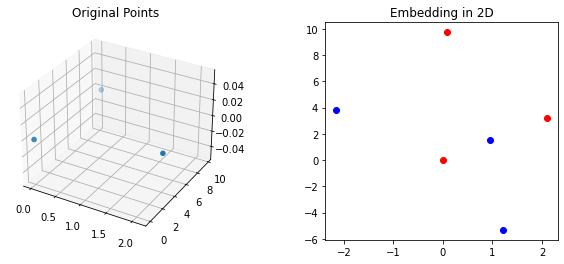

In [26]:
fig = plt.figure(2, (10,4))
ax = fig.add_subplot(121, projection='3d')
ax.scatter3D(coordinates[0,:], coordinates[1,:], coordinates[2,:])
plt.title('Original Points')

ax = fig.add_subplot(122)
plt.scatter(Sstar[0,:], Sstar[1,:],color='blue')
plt.scatter(S    [0,:], S    [1,:], color='red')
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

Introduction of the controlled displacement

In [27]:
deltaX = deltaY = 0.1

deltaSprime = np.array([[0 for i in range(n_robots)] for j in range(2)],dtype=float)
deltaSprime[:,0] = [deltaX,deltaY]
print(deltaSprime)

[[0.1 0.  0. ]
 [0.1 0.  0. ]]


In [28]:
Sprime = S + deltaSprime
print(Sprime)

[[0.1        2.10366473 0.07421331]
 [0.1        3.20535893 9.73246864]]


Phi prime definition

In [29]:
Phiprime = np.array([np.diag(Sprime.T@Sprime)]).T
print(Phiprime)

DMprime = Phiprime@e.T - 2*Sprime.T@Sprime + e@Phiprime.T

[[2.00000000e-02]
 [1.46997312e+01]
 [9.47264535e+01]]


Let's have a look at the distance matrices. They are pretty similar, since the displacement is very small. GOOD

In [30]:
print(DMprime)
print(DM)

[[ 0.         13.65792644 92.78511711]
 [13.65792644  0.         46.72183431]
 [92.78511711 46.72183431  0.        ]]
[[0.         3.83402284 9.73275159]
 [3.83402284 0.         6.83533718]
 [9.73275159 6.83533718 0.        ]]


DMprime breakdown analysis (as on the paper)

In [31]:
piece1 = DM2 - DMprime
print(piece1)

[[0.00000000e+00 1.04180473e+00 1.94133639e+00]
 [1.04180473e+00 0.00000000e+00 7.10542736e-15]
 [1.94133639e+00 7.10542736e-15 0.00000000e+00]]


In [32]:
piece2 = np.zeros((n_robots,n_robots))
piece2[1:,0] = (deltaX**2 + deltaY**2)*np.ones(n_robots-1)
piece2[0,1:] = (deltaX**2 + deltaY**2)*np.ones(n_robots-1)
print(piece2)

[[0.   0.02 0.02]
 [0.02 0.   0.  ]
 [0.02 0.   0.  ]]


In [33]:
piece3 = -2*((S.T@deltaSprime).T + S.T@deltaSprime)
print(piece3)

[[-0.         -1.06180473 -1.96133639]
 [-1.06180473 -0.         -0.        ]
 [-1.96133639 -0.         -0.        ]]


In [34]:
#FINAL RESULT [SHOULD BE VERY CLOSED TO ZERO --> GOOD]
print(piece1+piece2+piece3)

[[0.00000000e+00 2.44249065e-15 2.22044605e-15]
 [2.44249065e-15 0.00000000e+00 7.10542736e-15]
 [2.22044605e-15 7.10542736e-15 0.00000000e+00]]


In [35]:
a2 = DM2[0,1] - DMprime[0,1] + deltaX**2 + deltaY**2
b2 = -2*(Sstar[0,1]*deltaX + Sstar[1,1]*deltaY)    
c2 =  2*(Sstar[0,1]*deltaY - Sstar[1,1]*deltaX)    

a3 = DM2[0,2] - DMprime[0,2] + deltaX**2 + deltaY**2
b3 = -2*(Sstar[0,2]*deltaX + Sstar[1,2]*deltaY)     
c3 =  2*(Sstar[0,2]*deltaY - Sstar[1,2]*deltaX)    

sinTheta = (a3*b2-a2*b3)/(b3*c2-b2*c3)
cosTheta = (a2*c3-a3*c2)/(b3*c2-b2*c3)

theta = np.arctan2(sinTheta,cosTheta)
print('Theta: %f' % (theta))

mod = np.sqrt(sinTheta**2+cosTheta**2)
sinTheta /= mod
cosTheta /= mod
print(mod,sinTheta,cosTheta)
theta = np.arctan2(sinTheta,cosTheta)
print(np.rad2deg(theta))
#theta = np.pi/2 + theta
print(np.rad2deg(theta))
print('Theta: %f' % (theta))
print(sinTheta**2+cosTheta**2)


Theta: -0.853371
4.424812108206103 -0.7535008061651656 0.6574469827358291
-48.89454538964223
-48.89454538964223
Theta: -0.853371
1.0


In [36]:
#rotMatrix = np.array([[cosTheta,sinTheta],[-sinTheta,cosTheta]])
print(rotateMatrix(theta))

[[ 0.65744698 -0.75350081]
 [ 0.75350081  0.65744698]]


In [37]:
#Flip matrix
F = np.array([[-1,0],[0,1]])
print(F)

[[-1  0]
 [ 0  1]]


In [38]:
S2 = rotateMatrix(theta)@Sstar
S3 = rotateMatrix(theta)@F@Sstar

print(S2)
print(S)

fig = plt.figure(3, (15,4))
ax = fig.add_subplot(131)
plt.scatter(Sstar[0,:], Sstar[1,:], color=['orange','green' for i in range(1,n_robots)])
plt.scatter(S    [0,:], S    [1,:], color=['orange','green' for i in range(1,n_robots)])
plt.title('MDS')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(132)
plt.scatter(S2[0,:], S2[1,:], color=['orange','green' for i in range(1,n_robots)])
plt.scatter(S [0,:], S [1,:], color=['orange','green' for i in range(1,n_robots)])
plt.title('MDS w/ rotation')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(133)
plt.scatter(S3[0,:], S3[1,:], color=['orange','green' for i in range(1,n_robots)])
plt.scatter(S [0,:], S [1,:], color=['orange','green' for i in range(1,n_robots)])
plt.title('MDS w/ rotation and flip')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

SyntaxError: invalid syntax (1259584826.py, line 9)

In [ ]:

F = np.array([[-1,0],[0,1]])
print(F)

for i in range(n_robots-1):
    print((Sstar[0,i]-Sstar[0,i+1])**2 + (Sstar[1,i]-Sstar[1,i+1])**2 - 
    (S2[0,i]-S2[0,i+1])**2 - (S2[1,i]-S2[1,i+1])**2)

print(Sstar)
print(S2)

[[-1  0]
 [ 0  1]]
-2.842170943040401e-14
0.0
[[ 3.8399615  -3.76318499 -0.07677651]
 [ 2.71473963 -4.41422612  1.69948649]]
[[ 0.99539126 -2.58936908  1.59397781]
 [-4.59611921  5.19058005 -0.59446084]]
